In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

In [2]:
datadir = "/Users/usam/Desktop/Data/"
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

<ipython-input-2-d13d68d0cb33>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


center  \
0  /Users/usam/Desktop/Data/IMG/center_2021_07_12_18_03_08_469.jpg   
1  /Users/usam/Desktop/Data/IMG/center_2021_07_12_18_03_08_569.jpg   
2  /Users/usam/Desktop/Data/IMG/center_2021_07_12_18_03_08_673.jpg   
3  /Users/usam/Desktop/Data/IMG/center_2021_07_12_18_03_08_787.jpg   
4  /Users/usam/Desktop/Data/IMG/center_2021_07_12_18_03_08_905.jpg   

                                                             left  \
0   /Users/usam/Desktop/Data/IMG/left_2021_07_12_18_03_08_469.jpg   
1   /Users/usam/Desktop/Data/IMG/left_2021_07_12_18_03_08_569.jpg   
2   /Users/usam/Desktop/Data/IMG/left_2021_07_12_18_03_08_673.jpg   
3   /Users/usam/Desktop/Data/IMG/left_2021_07_12_18_03_08_787.jpg   
4   /Users/usam/Desktop/Data/IMG/left_2021_07_12_18_03_08_905.jpg   

                                                             right  steering  \
0   /Users/usam/Desktop/Data/IMG/right_2021_07_12_18_03_08_469.jpg  0.0        
1   /Users/usam/Desktop/Data/IMG/right_2021_07_12_18_03_08_569.jpg  0.0        
2   /Users/usam/Desktop/Data/IMG/right_2021_07_12_18_03_08_673.jpg  0.0        
3   /Users/usam/Desktop/Data/IMG/right_2021_07_12_18_03_08_787.jpg  0.0        
4   /Users/usam/Desktop/Data/IMG/right_2021_07_12_18_03_08_905.jpg  0.0        

   throttle  reverse     speed  
0  0.0       0.0      0.001872  
1  0.0       0.0      0.001877  
2  0.0       0.0      0.001832  
3  0.0       0.0      0.001842  
4  0.0       0.0      0.001958

In [3]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center                              left  \
0  center_2021_07_12_18_03_08_469.jpg  left_2021_07_12_18_03_08_469.jpg   
1  center_2021_07_12_18_03_08_569.jpg  left_2021_07_12_18_03_08_569.jpg   
2  center_2021_07_12_18_03_08_673.jpg  left_2021_07_12_18_03_08_673.jpg   
3  center_2021_07_12_18_03_08_787.jpg  left_2021_07_12_18_03_08_787.jpg   
4  center_2021_07_12_18_03_08_905.jpg  left_2021_07_12_18_03_08_905.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2021_07_12_18_03_08_469.jpg  0.0       0.0       0.0      0.001872  
1  right_2021_07_12_18_03_08_569.jpg  0.0       0.0       0.0      0.001877  
2  right_2021_07_12_18_03_08_673.jpg  0.0       0.0       0.0      0.001832  
3  right_2021_07_12_18_03_08_787.jpg  0.0       0.0       0.0      0.001842  
4  right_2021_07_12_18_03_08_905.jpg  0.0       0.0       0.0      0.001958

total data: 5852
removed: 3886
remaining: 1966


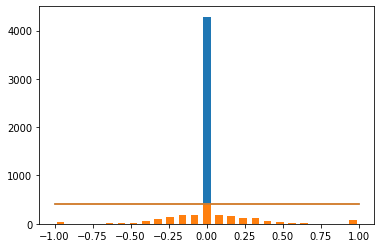

In [4]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))
 
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [5]:
print(data.iloc[1])
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
    # left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3])+0.15)
    # right image append
    image_path.append(os.path.join(datadir,right.strip()))
    steering.append(float(indexed_data[3])-0.15)
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

center      center_2021_07_12_18_03_09_015.jpg
left        left_2021_07_12_18_03_09_015.jpg  
right       right_2021_07_12_18_03_09_015.jpg 
steering    0.000000                          
throttle    0.000000                          
reverse     0.000000                          
speed       0.001848                          
Name: 5, dtype: object


In [6]:
""""What we're going to do is for every set of images we're going to plot the steering angles on a histogram
in order to visualize the distribution and see which steering angles are most frequent throughout the recording.

Plotting this histogram of training data shows us that the data we obtained from driving in track one has
more zeros angles because of the nature of the track as in most of the time we drove down the middle
of a straight track the left and right steering angle seemed to be pretty balanced.

And to improve this what we're going to do is reject all the samples above a certain threshold and make
sure that it is more uniform and not biased towards a specific steering angle.
So what we're going to do is specify a threshold of 200 that is samples per bin is going to equal 200
meaning that every Bin can only have a maximum of 200 samples to visualize this threshold.
"""



'"What we\'re going to do is for every set of images we\'re going to plot the steering angles on a histogram\nin order to visualize the distribution and see which steering angles are most frequent throughout the recording.\n\nPlotting this histogram of training data shows us that the data we obtained from driving in track one has\nmore zeros angles because of the nature of the track as in most of the time we drove down the middle\nof a straight track the left and right steering angle seemed to be pretty balanced.\n\nAnd to improve this what we\'re going to do is reject all the samples above a certain threshold and make\nsure that it is more uniform and not biased towards a specific steering angle.\nSo what we\'re going to do is specify a threshold of 200 that is samples per bin is going to equal 200\nmeaning that every Bin can only have a maximum of 200 samples to visualize this threshold.\n'

Training Samples: 4718
Valid Samples: 1180


Text(0.5, 1.0, 'Validation set')

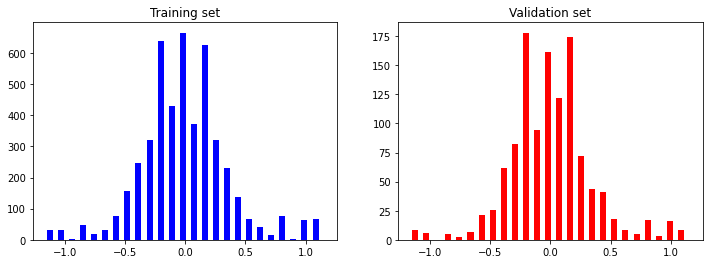

In [7]:
image_paths, steerings = load_img_steering(datadir + '/IMG', data)
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

Text(0.5, 1.0, 'Zoomed Image')

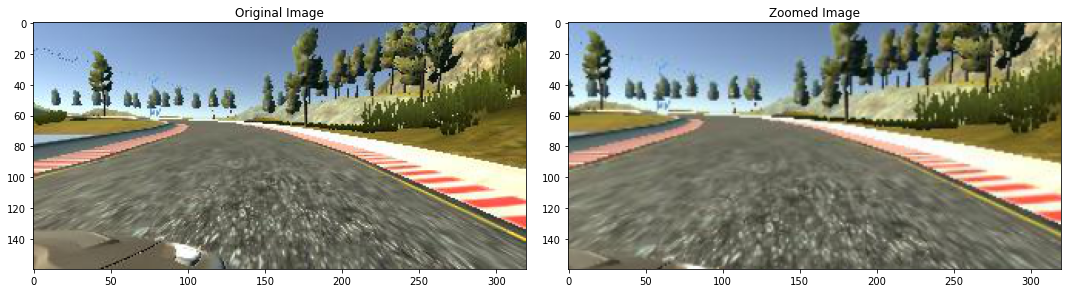

In [8]:
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')

Text(0.5, 1.0, 'Panned Image')

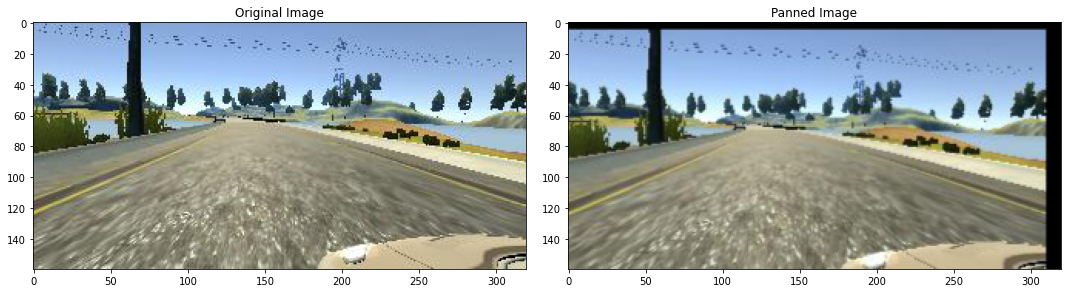

In [9]:
def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')

Text(0.5, 1.0, 'Brightness altered image ')

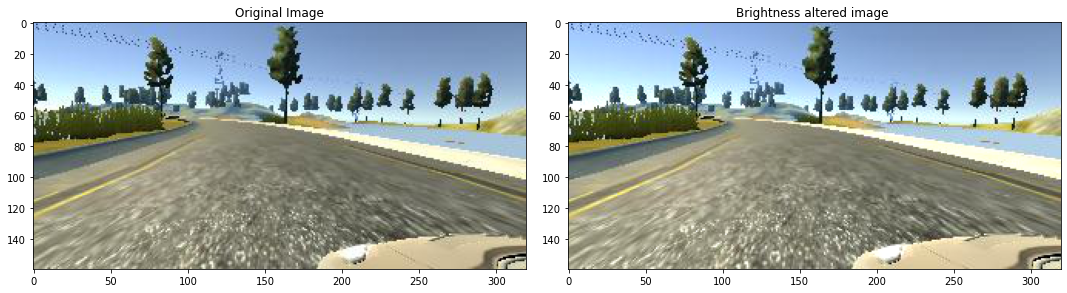

In [10]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
 
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')

Text(0.5, 1.0, 'Flipped Image - Steering Angle:0.3350941')

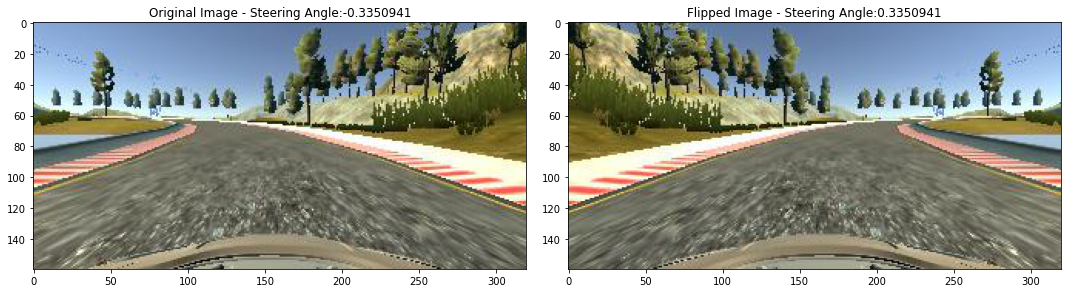

In [11]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]
 
 
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))
 
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

In [12]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = pan(image)
    if np.random.rand() < 0.5:
      image = zoom(image)
    if np.random.rand() < 0.5:
      image = img_random_brightness(image)
    if np.random.rand() < 0.5:
      image, steering_angle = img_random_flip(image, steering_angle)
    
    return image, steering_angle

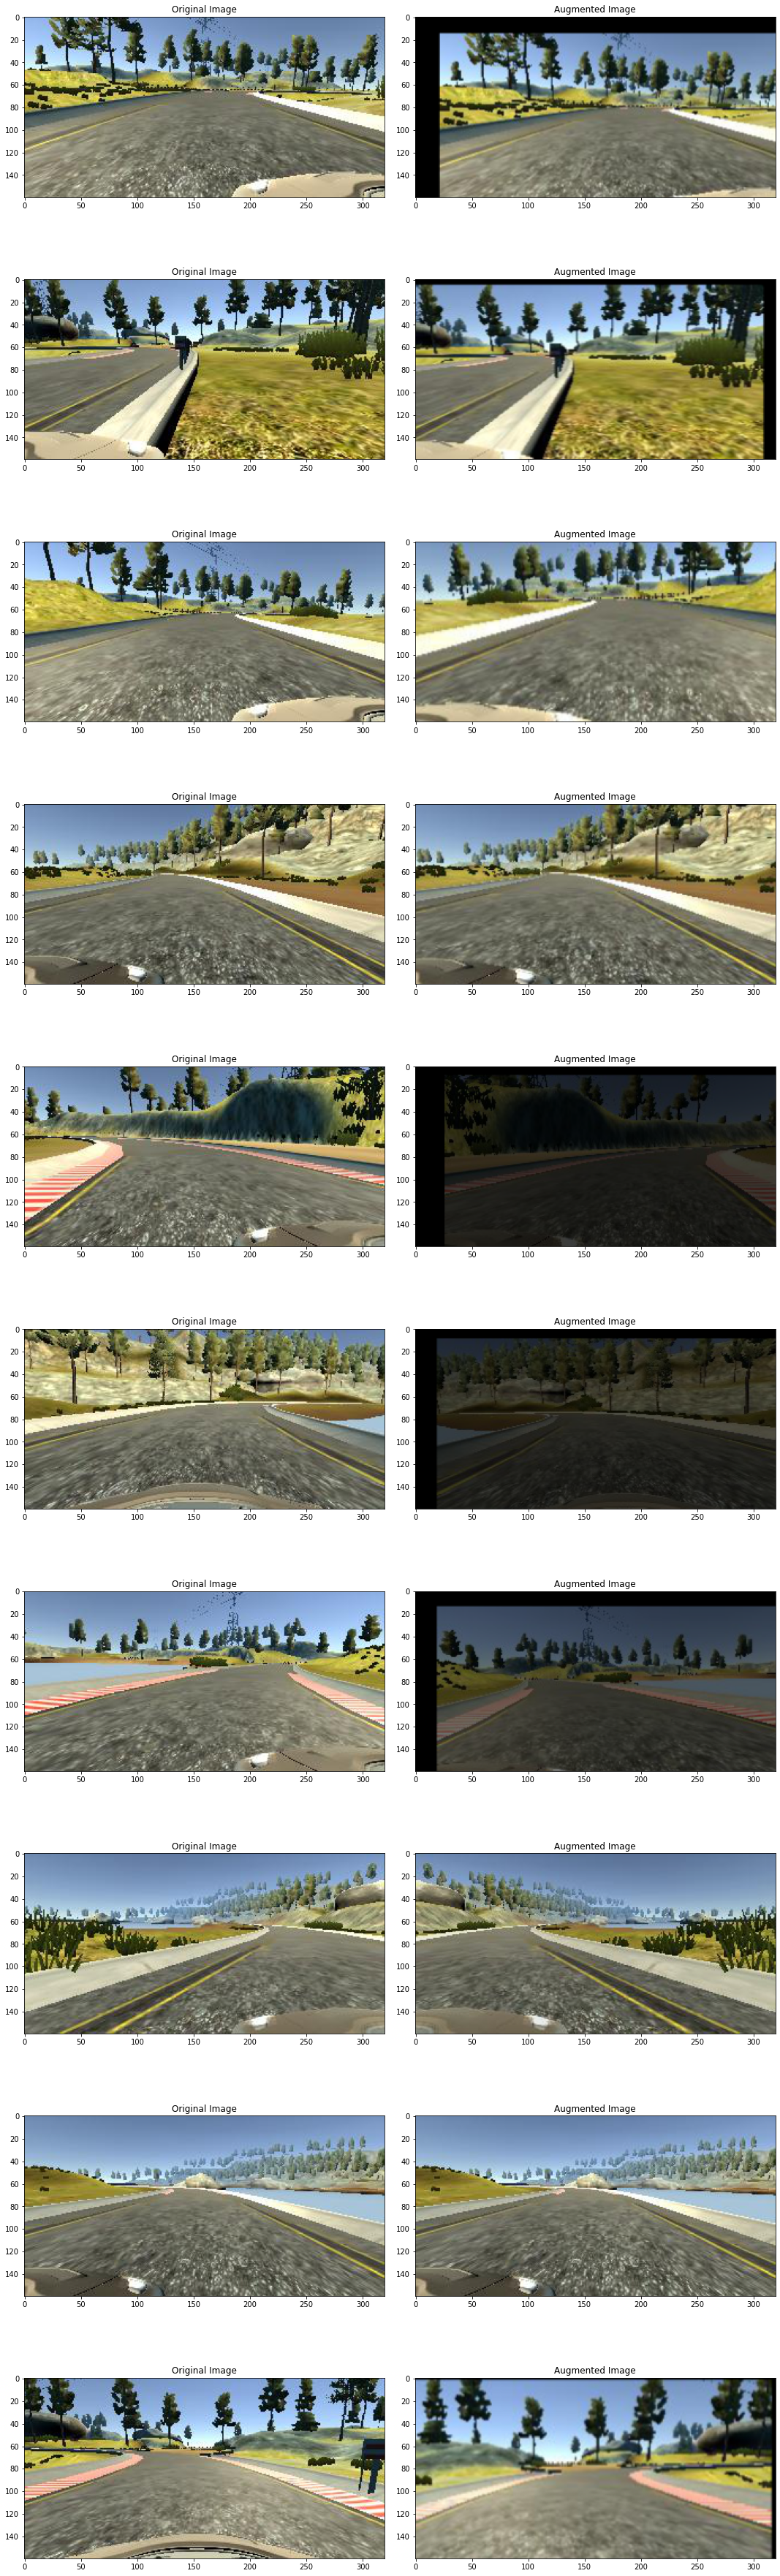

In [13]:
ncol = 2
nrow = 10
 
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()
 
for i in range(10):
  randnum = random.randint(0, len(image_paths) - 1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
    
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
    
  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image")
  
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image")

Text(0.5, 1.0, 'Preprocessed Image')

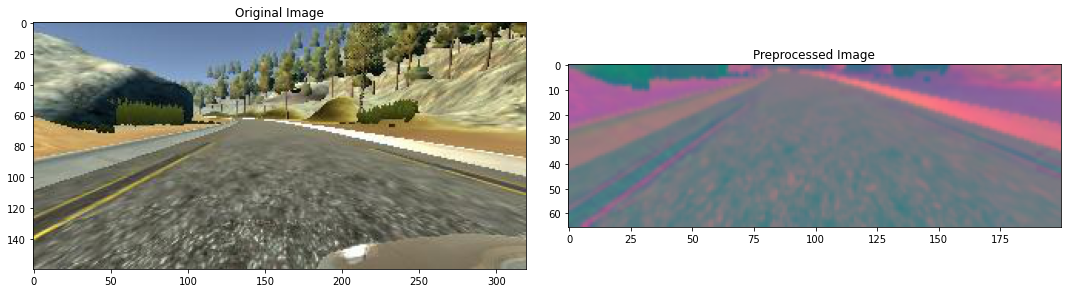

In [14]:
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [15]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  
  while True:
    batch_img = []
    batch_steering = []
    
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      
      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
     
      else:
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]
      
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)

x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))
 
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
 
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')
 
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

In [16]:
def nvidia_model():
    model = Sequential()
    model.add(Conv2D(24, 5, 5, strides=(2,2), input_shape=(66, 200, 3), activation='elu'))
    model.add(Conv2D(36, 5, 5, strides=(2,2), activation='elu'))
    model.add(Conv2D(48, 5, 5, strides=(2,2), activation='elu'))
    model.add(Conv2D(64, 3, 3, activation='elu'))
  
    model.add(Conv2D(64, 3, 3, activation='elu'))
    #   model.add(Dropout(0.5))


    model.add(Flatten())

    model.add(Dense(100, activation = 'elu'))
    #   model.add(Dropout(0.5))

    model.add(Dense(50, activation = 'elu'))
    #   model.add(Dropout(0.5))

    model.add(Dense(10, activation = 'elu'))
    #   model.add(Dropout(0.5))

    model.add(Dense(1))

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mse', opt=optimizer)
    return model

In [17]:
def nvidia_model():
    model = Sequential()
    model.add(Conv2D(filters = 24, kernel_size = (5, 5), strides=(2,2), input_shape=(66, 200, 3), activation='elu'))
    model.add(Conv2D(filters =36, kernel_size = (5, 5), strides=(2,2), activation='elu'))
    model.add(Conv2D(filters =48, kernel_size = (5, 5), strides=(2,2), activation='elu'))
    model.add(Conv2D(filters =64, kernel_size = (3, 3), activation='elu'))
  
    model.add(Conv2D(filters =64, kernel_size = (3, 3), activation='elu'))
    #   model.add(Dropout(0.5))


    model.add(Flatten())

    model.add(Dense(100, activation = 'elu'))
    #   model.add(Dropout(0.5))

    model.add(Dense(50, activation = 'elu'))
    #   model.add(Dropout(0.5))

    model.add(Dense(10, activation = 'elu'))
    #   model.add(Dropout(0.5))

    model.add(Dense(1))

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer="Adam", loss="mse")
    return model

In [18]:
import time

start = time.time()

In [19]:
model = nvidia_model()
print(model.summary())
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                                  steps_per_epoch=300, 
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               1

KeyboardInterrupt: 

In [ ]:
model.save('model.h5')

In [ ]:
end = time.time()
exec_time= end - start
print(f"Took in total to train: {exec_time / 60} mins.)

In [28]:
from IPython.display import Markdown, display
display(Markdown("writeup_template.md"))

# Udacity Self-Driving Car Engineer Nanodegree - Behavioral Cloning Project

*My solution to the Udacity Self-Driving Car Engineer Nanodegree Behavioral Cloning project.*

**Note: This project makes use of a Udacity-developed driving simulator and training data collected from the simulator (neither of which is included in this repo).**

### Introduction

The objective of this project is to teach the computer to drive car on on the basis of data collected in simulator provided by Udacity [here](.amazonaws.com/video.udacity-data.com/topher/2016/December/584f6edd_data/data.zip). Here the concepts of Deep Learning and Convolutional Neural Networks are applied to teach the computer to drive car autonomously.

I collected the data using the Simulator provided by Udacity and then feeded it to my model. This data is fed in the form of images captured by 3 dashboard cams center, left and right. The output data contains a file data.csv which has the mappings of center, left and right images and the corresponding steering angle, throttle, brake and speed. 

Using Keras Deep learning framework a model.h5 file was created, which sothat the model could be tested using the simulator in autonomous mode with the command "python drive.py model.h5". This drive.py connects the model to simulator. The challenge in this project is to collect all sorts of training data so as to train the model to respond correctly in any type of situation.

Since I also previously took part at Udemy Course for [Self Driving Car](.https://www.udemy.com/course/applied-deep-learningtm-the-complete-self-driving-car-course/) a used the knowledges obtrained from this course to complete this project. 

---

**Behavioral Cloning Project**

The goals / steps of this project are the following:
* Use the simulator to collect data of good driving behavior
* Build, a convolution neural network in Keras that predicts steering angles from images
* Train and validate the model with a training and validation set
* Test that the model successfully drives around track one without leaving the road
* Summarize the results with a written report


### Files Submitted & Code Quality

#### 1. Submission includes all required files and can be used to run the simulator in autonomous mode

My project includes the following files:
* model.py containing the script to create and train the model
* model.ipynb python notebook containing the code to create and train the model
* drive.py for driving the car in autonomous mode
* model.h5 containing a trained convolution neural network 
* writeup_report.md  summarizing the results

#### 2. Submission includes functional code

Using the Udacity provided simulator and my drive.py file, the car can be driven autonomously around the track by executing 
```sh
python drive.py model.h5
```

#### 3. Submission code is usable and readable

The model.py file contains the code for training and saving the convolution neural network. The file shows the pipeline I used for training and validating the model, and it contains comments to explain how the code works.


### Model Architecture and Training Strategy

#### 1. An appropriate model architecture has been employed

* I decided to test the model provided by NVIDIA as suggested by Udacity. The model architecture is described by NVIDIA: <img src="./writeup_imgs/nvidia_model.png" width="500" height="800"/> The network has about 27 million connections and 250 thousand
parameters.

As an input this model takes in image of the shape (60,266,3) but our dashboard images/training images are of size (160,320,3). I decided to keep the architecture of the model same but instead preprocess the images to hast the shape of (66, 200, 3).


I applied a whole pipeline of image preprocessing and augmentations steps consisting different techniques described bellow: 


###  Creation of the Training Set & Training Process

To capture good driving behavior, I first recorded 3 laps on track one using center lane driving. Here is an example image of center lane driving:
Since the the track in Simulator has more left curves an decided to drive the car in backward direction for other 3 laps to avoid bias in data and to get more balanced data set.

* Sample Image:
<img src="./writeup_imgs/sample_center.png" width="500" height="500" />


### Preprocessing

Image data preprocessing and augmentation can be used to improve model performance and reduce generalization error.
This process allows creating of new data images using the existing dataset. Since our data set is relatively not big,
some data augmenation techniques must be applied for better model generalization and to avoid overfitting. 
The applied image preprocessing technique are desribed bellow: 

##### Image Zooming 

The first data augmentation technique used is zooming. 
With this step an image can be zoomed in up to 30 percent: 
<img src="./writeup_imgs/zoomed.png" width="800" height="800" />

##### Image Panning 
Now we can move on to our next augmentation technique called `Image Panning` which is essentially just the horizontal or vertical translation of the image.
<img src="./writeup_imgs/translated.png" width="800" height="800" />

##### Brightness Altering 
The next augmentation is altering of image brightness. What this function does is essentially playing around with the brightness of the image making it darker or lighter.
The function multiplies all the image pixels inside the image with a specific value.
 
<img src="./writeup_imgs/brightness_tr.png" width="800" height="800" />

##### Image Flipping 

The next augmenatation technique is known as `Image Flipping`. Randomly flipping provides aditional images which helps to balance our dataset.
<img src="./writeup_imgs/flipped.png" width="800" height="800" />


These four augmentations that were presented above adds enough variety to our data set to improve the quality of the training process.


##### Image Cropping 
In the images of our data set we can see that there are a lot of features that are not very important to focus on. 
For example the top of our image is almost entirely just a scenery consisting of trees and mountains. While the very bottom of the image is just the hood of the car. These features are not relevant as there is no relationship between the scenery surrounding the road and the steering angle of the car. For this reason all images were cropped using the `cv2.resize(img, (200, 66))` function to remove the unnecessary features.


##### Color Space convertion
The Nvidia model architects themselves recommend the usage of YUV color space as opposed to default RGB format or even
a greyscale image.
For this reason I converted the color space to YUV using appropreated cv2 function.
The next technique I applied was the addition of a gaussian blur using `cv2.GaussianBlur` because it helps smoothing the image out and to reduce noise within the image.

<img src="./writeup_imgs/color_cvt.png" width="800" height="800" />


### Final Model Architecture

#### 3. Model parameter tuning

* No of epochs: 10
* Optimizer Used: Adam
* Steps per epoch: 300
* Learning Rate: 0.001
* Validation Data split 0.2
* Generator batch size: 100
* Validation steps: 200
* Loss Function Used- MSE(Mean Squared Error as it is efficient for regression problem).

#### 4. Appropriate training data

Training data was chosen to keep the vehicle driving on the road. I used a combination of center lane driving, recovering from the left and right sides of the road ... 

For details about how I created the training data, see the next section. 

### Model Architecture and Training Strategy

#### 1. Solution Design Approach

The overall strategy for deriving a model architecture was to ...

My first step was to use a convolution neural network model similar to the ... I thought this model might be appropriate because ...

In order to gauge how well the model was working, I split my image and steering angle data into a training and validation set. I found that my first model had a low mean squared error on the training set but a high mean squared error on the validation set. This implied that the model was overfitting. 

To combat the overfitting, I modified the model so that ...

Then I ... 

The final step was to run the simulator to see how well the car was driving around track one. There were a few spots where the vehicle fell off the track... to improve the driving behavior in these cases, I ....

At the end of the process, the vehicle is able to drive autonomously around the track without leaving the road.

#### 2. Final Model Architecture

Here is a visualization of my final mnodel architecture. As I said there was no changes made to the NVIDIA model that I choosed for this project.  

<img src="./writeup_imgs/model_summary.png" width="600" height="600" />





In [ ]:
#It's clear that the data isn't exactly similar but both follow a general trend such that both right and left steering angles are somewhat balanced they're pretty balanced.

"""
Looking at our image we can see that there are a lot of features that are not very important to focus on.
For example the top of our image is almost entirely just scenery consisting of trees and mountains.
While the very bottom of our image is just the hood of our own car these features are not relevant for
helping our car determine the steering angle as there is no relationship between the scenery surrounding
the road and the steering angle of our car. For this reason we can crop our image to remove it."""

As you can see the unnecessary features were removed.
This will allow our model to focus on the more important features of the image such as the lane lines
and the borders.

As you might recall However as mentioned earlier there are many other neural architectures that we can
choose from in this particular course we are going to rely on the more complex invidia model the architecture
of which I will discuss further in the section. This however is relevant for pre-processing because the nvidia model architects themselves recommend
that we use the Y U v color space for over a dataset as opposed to the default RGB format or even a greyscale image. For this reason we will also convert our color space to y u v.

In [ ]:
"""A popular model used for behavioral cloning is called the nvidia model.
This model is proposed by invidia and is discussed in detail inside the article end to end learning"""

###Data augmentations
But then on the second track it did not generalize to it at all as it failed almost immediately.
This is essentially due to the small dataset that our model was trained on in order to tackle this issue
of a small dataset.
Let's revisit the data augmentation technique that we introduced in our previous section data augmentation
is the process of creating new data images using your existing dataset.

And this is where we are going to implement the image library we call
and we call the zoom augmentation function.

It would be more useful to zoom in to the image rather than out for improved feature extraction which
means that we will start our range at one which implies no zoom and we will define the upper limit of our
range as of one point three.
Which means that we can zoom up to 30 percent into our image.


Now we can move on to our next augmentation image panning image panning is essentially just the horizontal or vertical translation of the image.

altering brightness:
Now we can move to our next augmentation which is altering brightness which we will define in a new image.
And what this function is essentially going to do is play around with the brightness of the image making

it darker or lighter.

What this does is it essentially multiplies all the images inside the image with a specific value.

Making the image darker if the value is less than one and brighter if the value is larger than one we.

Flipping: 
Let us first create a new cell and this final augmentation technique is known as flipping.
randomly flipping provides aditional image which helps to balance our datasets.


These four augmentations that we just applied should be sufficient for our purposes and should add enough
variety to our data set to improve the quality of our training process.


We are going to write a code that causes a certain augmentation function to run 50 percent of the time.
OK with this simple code we have randomize the occurrence of our augmentation functions in a rather
elegant way.

And now that we finalized our augmentations let's plot some fully augmented images with combined augmentation

techniques.